In [1]:
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(101)

2024-08-22 22:34:37.746521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 22:34:37.746649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 22:34:37.871517: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# EDA

In [2]:
os.listdir('../input/histopathologic-cancer-detection')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [3]:
print(len(os.listdir('../input/histopathologic-cancer-detection/train')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test')))

220025
57458


In [4]:
# Load the training labels
labels_df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

# Display the first few rows
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


label
0    130908
1     89117
Name: count, dtype: int64


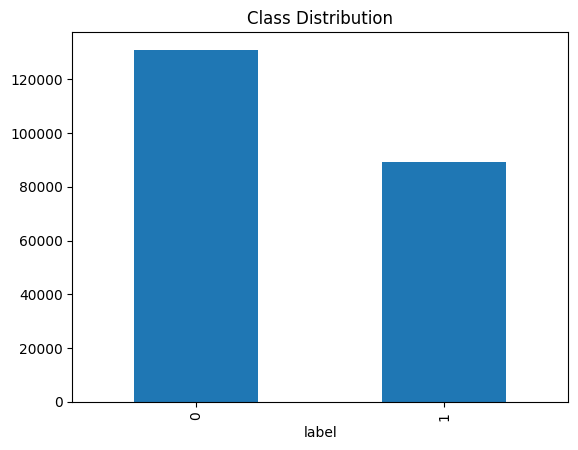

In [5]:
# Check for class imbalance
print(labels_df['label'].value_counts())

# Plot the distribution
labels_df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.show()

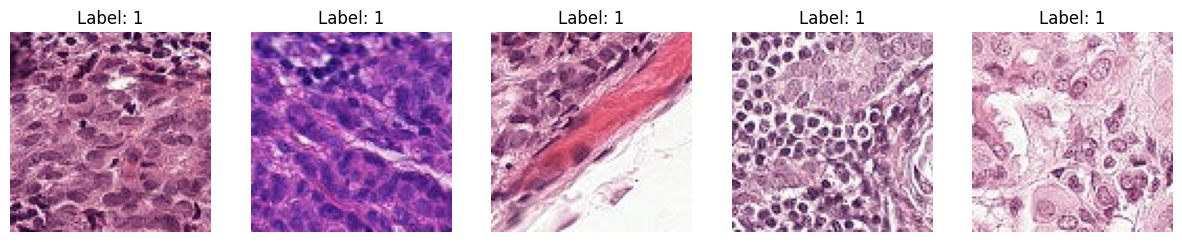

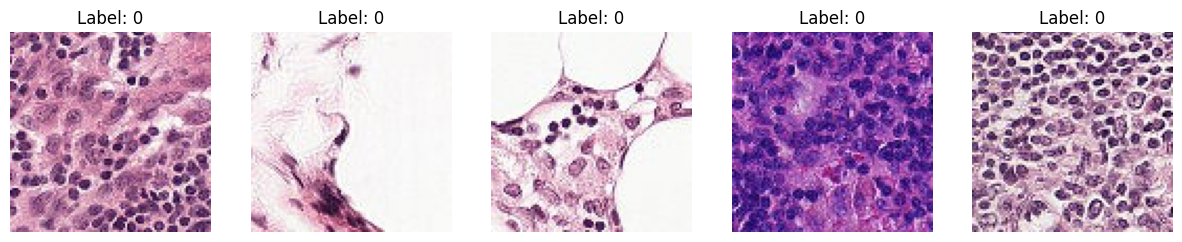

In [6]:
def plot_sample_images(df, label, n=5):
    # Get a random sample of n images with the specified label
    sample_df = df[df['label'] == label].sample(n)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sample_df.index):
        img_path = os.path.join('../input/histopathologic-cancer-detection/train', sample_df.loc[idx, 'id'] + '.tif')
        img = cv2.imread(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# Visualize tumor samples
plot_sample_images(labels_df, label=1)

# Visualize non-tumor samples
plot_sample_images(labels_df, label=0)

# Data Preprocessing

In [7]:
# Separate the data into two DataFrames based on labels
label_0_df = labels_df[labels_df['label'] == 0]
label_1_df = labels_df[labels_df['label'] == 1]

# Randomly sample 50000 from each DataFrame
label_0_sampled = label_0_df.sample(50000, random_state=101)
label_1_sampled = label_1_df.sample(50000, random_state=101)

# Concatenate the sampled DataFrames to create a balanced dataset
balanced_df = pd.concat([label_0_sampled, label_1_sampled])

# Shuffle the DataFrame to mix up the samples
balanced_df = shuffle(balanced_df, random_state=101)

# Split the balanced dataset into training and validation sets
train_df, val_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['label'], random_state=101)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")


Training set size: 80000
Validation set size: 20000


In [8]:
# Convert labels to strings
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

# Append '.tif' extension to the 'id' column
train_df['id'] = train_df['id'] + '.tif'
val_df['id'] = val_df['id'] + '.tif'

# Model

In [9]:
# Image data generator for augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    directory='../input/histopathologic-cancer-detection/train', 
    x_col='id', 
    y_col='label', 
    target_size=(96, 96), 
    batch_size=32, 
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df, 
    directory='../input/histopathologic-cancer-detection/train', 
    x_col='id', 
    y_col='label', 
    target_size=(96, 96), 
    batch_size=32, 
    class_mode='binary'
)

Found 80000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.


In [10]:
# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,778,945 (25.86 MB)

 Trainable params: 6,778,945 (25.86 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Set callbacks
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(patience=3, monitor='val_loss'),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-08-22 22:41:21.935504: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8836: 6.17839, expected 5.44963
2024-08-22 22:41:21.935559: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8839: 5.09095, expected 4.36218
2024-08-22 22:41:21.935568: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8843: 6.28436, expected 5.55559
2024-08-22 22:41:21.935576: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8845: 5.83888, expected 5.11011
2024-08-22 22:41:21.935584: E external/local_xla/xla/service/gpu/buffer_comp

   1/2500 ━━━━━━━━━━━━━━━━━━━━ 7:17:59 11s/step - accuracy: 0.5000 - loss: 0.7081

I0000 00:00:1724366485.811334      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1024s 406ms/step - accuracy: 0.7338 - loss: 0.5331 - val_accuracy: 0.7455 - val_loss: 0.5361 - learning_rate: 1.0000e-04
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 392s 156ms/step - accuracy: 0.7874 - loss: 0.4652 - val_accuracy: 0.7590 - val_loss: 0.5045 - learning_rate: 1.0000e-04
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 398s 159ms/step - accuracy: 0.8081 - loss: 0.4296 - val_accuracy: 0.8129 - val_loss: 0.4296 - learning_rate: 1.0000e-04
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 403s 161ms/step - accuracy: 0.8201 - loss: 0.4041 - val_accuracy: 0.7918 - val_loss: 0.4871 - learning_rate: 1.0000e-04
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 424s 169ms/step - accuracy: 0.8303 - loss: 0.3838 - val_accuracy: 0.8084 - val_loss: 0.5071 - learning_rate: 1.0000e-04
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 393s 157ms/step - accuracy: 0.8387 - loss: 0.3693 - val_accuracy: 0.8163 - val_loss: 0.4460 - learning_rate: 1.0000e-04
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━

# Model Eval & Submission

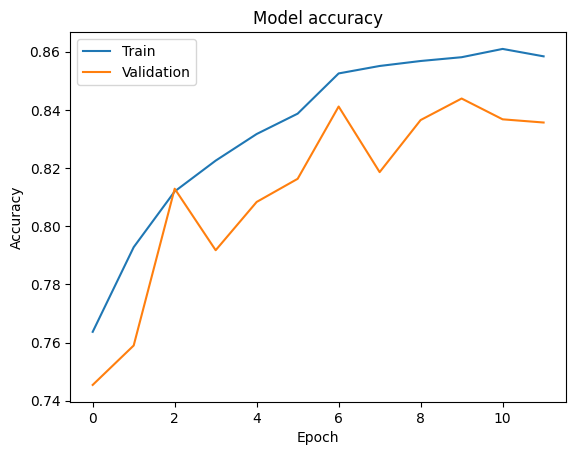

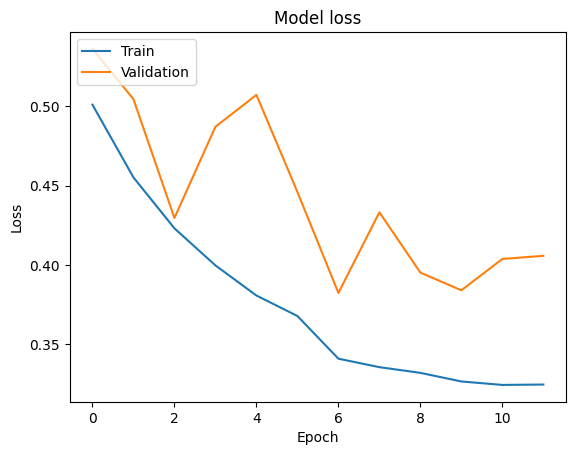

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
# Load the test dataset
test_ids = os.listdir('../input/histopathologic-cancer-detection/test')

# Pre-process the test images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory='../input/histopathologic-cancer-detection/',
    classes=['test'],
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Make predictions
predictions = model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int)

predicted_ids = [os.path.splitext(os.path.basename(f))[0] for f in test_generator.filenames]

# Prepare the submission file
submission_df = pd.DataFrame({'id': predicted_ids, 'label': predicted_labels.flatten()})
submission_df.to_csv('submission.csv', index=False)

Found 57458 images belonging to 1 classes.
1795/1796 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step

2024-08-23 00:23:22.261405: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1169: 5.18307, expected 4.53467
2024-08-23 00:23:22.261493: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1539: 5.09214, expected 4.44374
2024-08-23 00:23:22.261514: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2187: 5.47877, expected 4.83037
2024-08-23 00:23:22.261557: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4250: 5.16469, expected 4.51629
2024-08-23 00:23:22.261581: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5885: 5.34781, expected 4.69941
2024-08-23 00:23:22.261611: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8836: 6.81719, expected 5.85922
2024-08-23 00:23:22.261622: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8837: 7.96806, expected 7.01009
2024-08-23 00:23:22.261632: E exte

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 525s 292ms/step


In [14]:
submission_df = pd.read_csv('submission.csv')
submission_df.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,1
4,000270442cc15af719583a8172c87cd2bd9c7746,0
